### Nature Medicine -  _Single-cell meta-analysis of SARS-CoV-2 entry genes across tissues and demographics_
#### This Notebook generates Figure 5 c) - h)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
out_folder = "/GitHub/Covid_meta_analysis/Figure5_scData_Mouse_Models/"

from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

import warnings
warnings.filterwarnings("ignore")
sc.logging.print_version_and_date()

Running Scanpy 1.5.1, on 2020-10-24 11:32.


### Read in Meta Data File and generate annData Object

In [2]:
tab = pd.read_csv(out_folder + "HCA_Covid19_smokedMice_metadata.txt", sep = "\t", index_col = 0)
tab.head(2)

,umap_1,umap_2,cell_type,condition,sample_id,n_counts,n_genes,Ace2_category,Ace2,Tmprss2,...,Vegfa,Sec14l3,Ccdc153,Cyp2f2,Tppp3,Cyp2s1,Scgb1a1,Cbr2,Hp,Scgb3a2
cell_barcode,,,,,,,,,,,,,,,,,,,,,
muc13913_CTGCTTGTCTTT,3.439284,9.978938,Inhba+ macrophhages,smoked,SMK-2m-2,6000.0,1611,Ace2-,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
muc13913_TCTATACAGTCC,-4.193639,-4.814099,EC,smoked,SMK-2m-2,5996.0,1534,Ace2-,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.643279,2.397767,0.0


In [3]:
adata = sc.AnnData(X = tab.iloc[:, 8:], obs = tab.iloc[:, 2:8])
adata.obsm["X_umap"] = tab.loc[:, ["umap_1", "umap_2"]].values
adata.obs["Ace2_positive"] = ["Ace2+" if a != "Ace2-" else "Ace2-" for a in adata.obs.Ace2_category]
adata.obs["celltype_condition"] = ["%s_%s" %(ct, cond) for ct, cond in zip(adata.obs.cell_type, adata.obs.condition)]

sc._utils.sanitize_anndata(adata)
adata

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'sample_id' as categorical
... storing 'Ace2_category' as categorical
... storing 'Ace2_positive' as categorical
... storing 'celltype_condition' as categorical


AnnData object with n_obs × n_vars = 20261 × 21
    obs: 'cell_type', 'condition', 'sample_id', 'n_counts', 'n_genes', 'Ace2_category', 'Ace2_positive', 'celltype_condition'
    obsm: 'X_umap'

### Plotting Functions

In [4]:
sc.set_figure_params(vector_friendly = True)
plt.rcParams["figure.figsize"] = [6, 5]
sb.set_style("ticks")

def calc_relFreq(a, group_by = "cell_type", xlabel = "days"):
    freqs = a.obs.groupby(["sample_id", group_by]).size()
    samples = np.unique(a.obs["sample_id"])
    ind = a.obs[group_by].cat.categories
    
    relFreqs = [freqs[ident] / sum(freqs[ident]) for ident in samples]
    relFreqs = pd.DataFrame(relFreqs, columns = ind, index = samples).fillna(0)

    cell_types = {}
    combis = a.obs.groupby(["sample_id", xlabel]).groups.keys()

    for c in combis:
        cell_types[c[0]] = c[1]
    relFreqs[xlabel] = [cell_types[l] for l in relFreqs.index]
    
    return relFreqs

def plot_cluster_composition(relFreqs, xlabel = "name", figsize = (6, 10), width = 0.8, order = None,
                             errbar = None, capsize = None, margins = (0.02, 0.04), cols = None, cell_type = None):
    import matplotlib.patches as mpatches
    
    patches = []
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize)
    order = np.unique(relFreqs.loc[:, xlabel]) if order is None else order
    ci = 95 if errbar else None
    ax.margins(margins[0], margins[1])
    cell_types = np.flip([col for col in relFreqs.columns if col not in ["sample_id", xlabel]])
    
    bars = pd.DataFrame(index = order, data = np.zeros(len(order)))
    plot_data = pd.DataFrame(relFreqs.loc[:, xlabel])

    for i, typ in enumerate(cell_types):
        sum_up = [relFreqs.loc[:, typ].values[i] + bars.loc[g].values[0] for i, g in enumerate(relFreqs.loc[:, xlabel])]
        plot_data[typ] = sum_up
        bars.iloc[:, 0] = bars.iloc[:, 0] + relFreqs.loc[:, [typ, xlabel]].groupby(xlabel).mean().loc[order, typ]

    for i, typ in enumerate(reversed(cell_types)):
        fig = sb.barplot(data = plot_data, x = xlabel, y = typ, order = order,
                         ci = ci, errcolor = "black", color = cols[i], capsize = capsize)
        fig = sb.stripplot(data = plot_data, x = xlabel, y = typ, palette = ["black"])
        patches.append(mpatches.Patch(color = cols[i], label = typ))

    ax.set_xlabel(xlabel, size = 15)
    ax.set_ylabel("relative frequency", size = 15)
    ax.tick_params(labelsize = 13)
    ax.set_xticklabels(labels = order, rotation = 45)
    ax.set_title(cell_type)
    sb.despine()
    
    for bar in fig.patches:
        centre = bar.get_x() + bar.get_width()/2.
        bar.set_x(centre - width/2.)
        bar.set_width(width)

    plt.legend(handles = patches, loc = "center left", bbox_to_anchor=(1.02, 0.5),
               prop = {"size": 13}, frameon = False)
    plt.show()
    plt.close()
    

### Cell Type Annotation of scRNA-seq Data

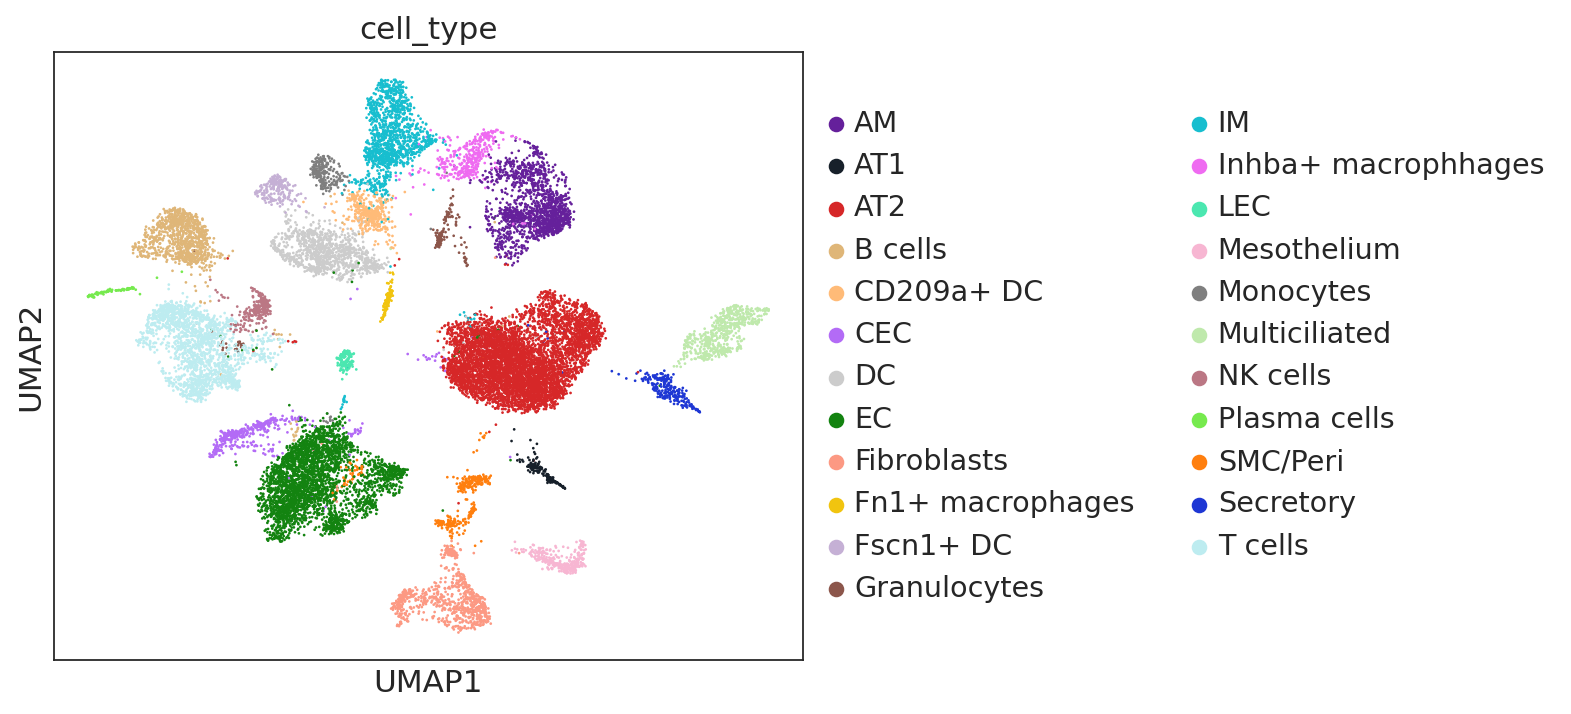

In [5]:
adata.uns["cell_type_colors"] = ['#65209B', '#17202A', '#d62728', '#DFB678', '#ffbb78', '#B36BF6',
                                 '#CCCCCC', '#138310', '#FC9983', '#F1C40F', '#c5b0d5', '#8c564b',
                                 '#17becf', '#EF6BF1', '#4BE7B0', '#f7b6d2', '#7f7f7f', '#BFE9AC',
                                 '#bb7784', '#76EA4E', '#ff7f0e', '#1E37D4', '#BDECF0']

sc.pl.umap(adata, color = "cell_type")

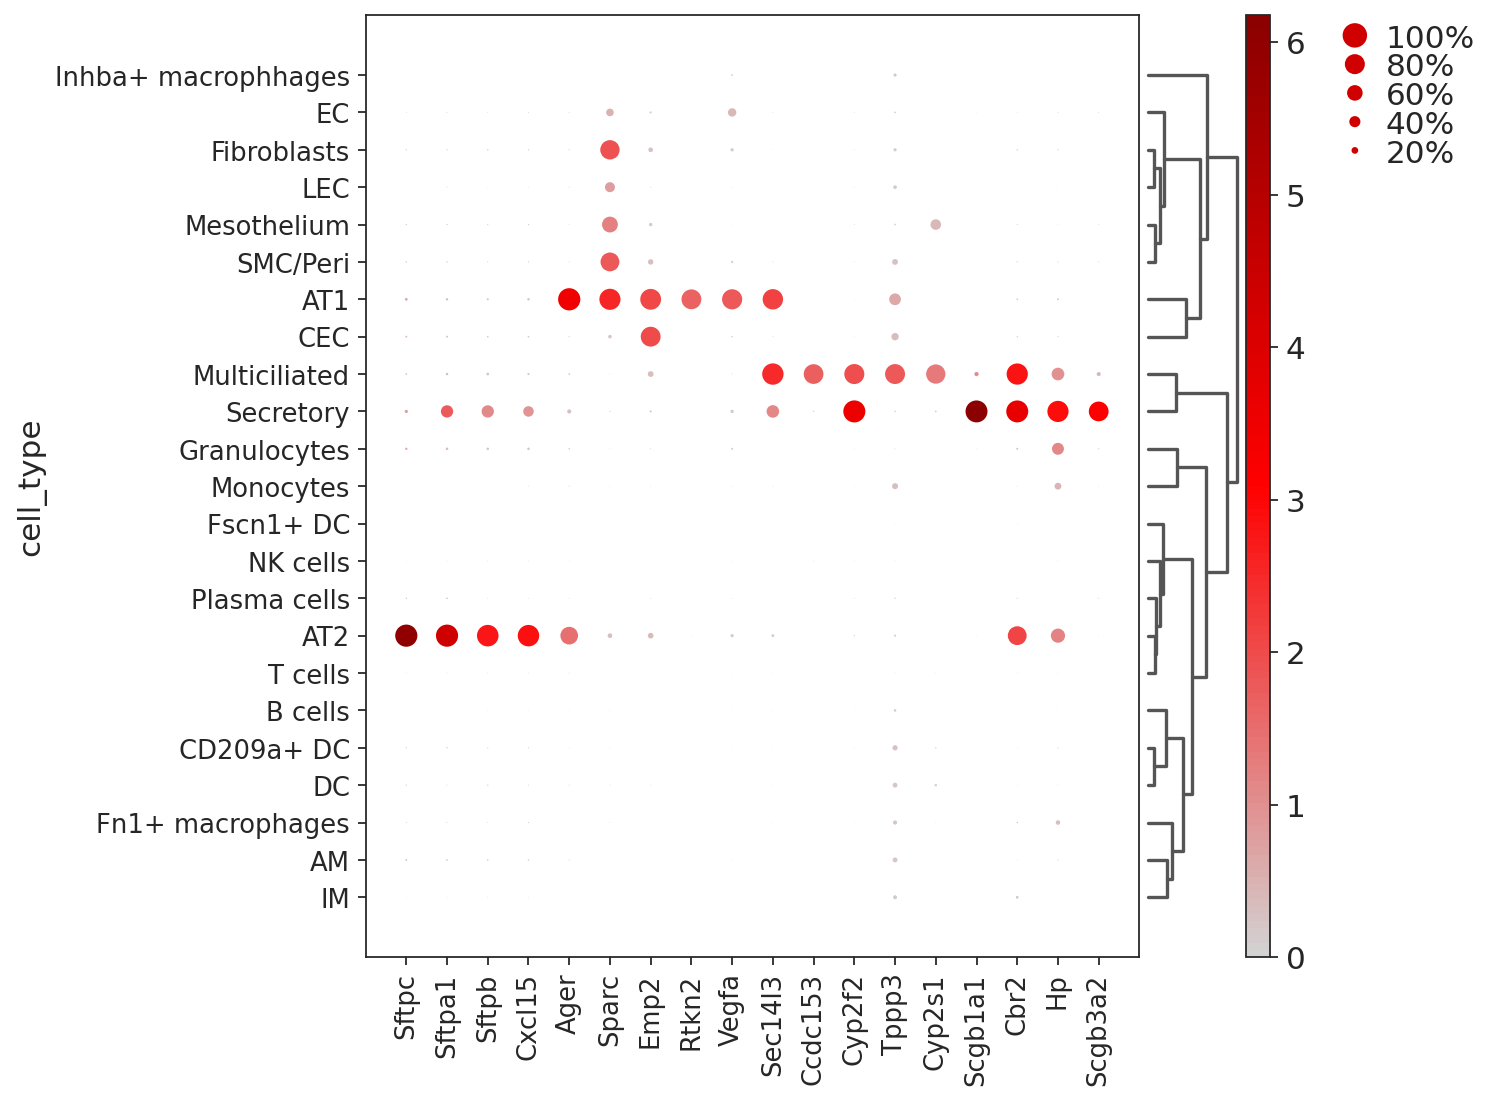

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[6.3, 0.8, 0.2, 0.5, 0.25])

In [6]:
## Epithelial cell type markers
sc.tl.dendrogram(adata, groupby = "cell_type")
sc.pl.dotplot(adata, var_names = adata.var_names[3:], groupby = "cell_type", 
              color_map = gray_red, dendrogram = True)

### Figure 5 c) UMAP of scRNA-seq profiles colored by experimental group

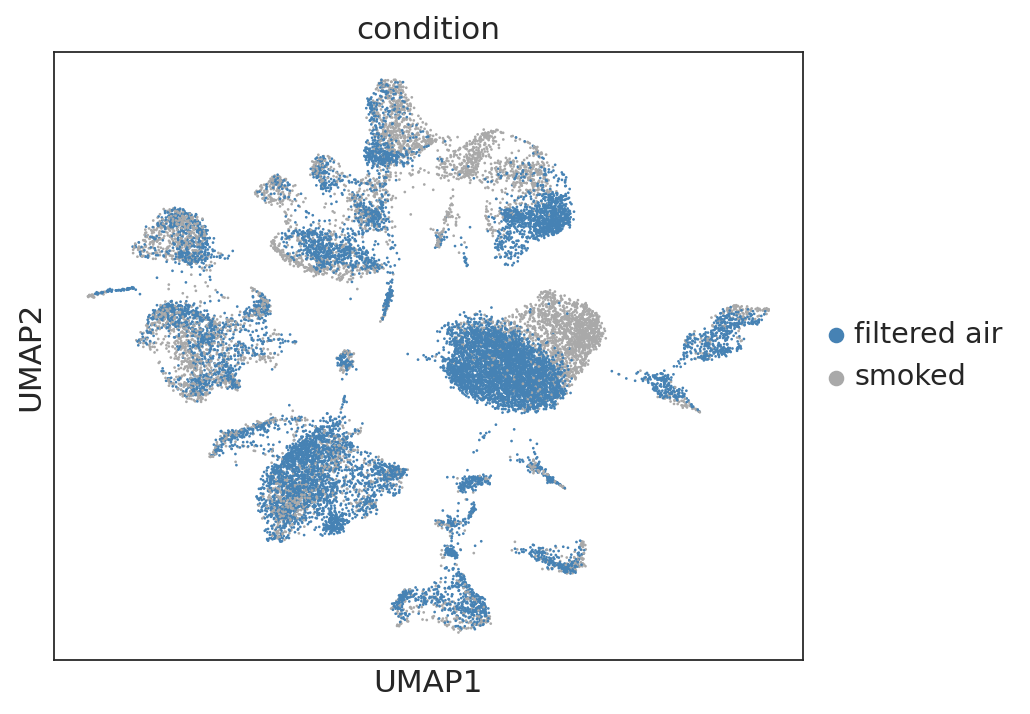

In [7]:
sc.pl.umap(adata, color = "condition", palette = ["steelblue", "darkgray"])

### Figure 5 d) UMAP of scRNA-seq profiles colored by Ace2+ cells

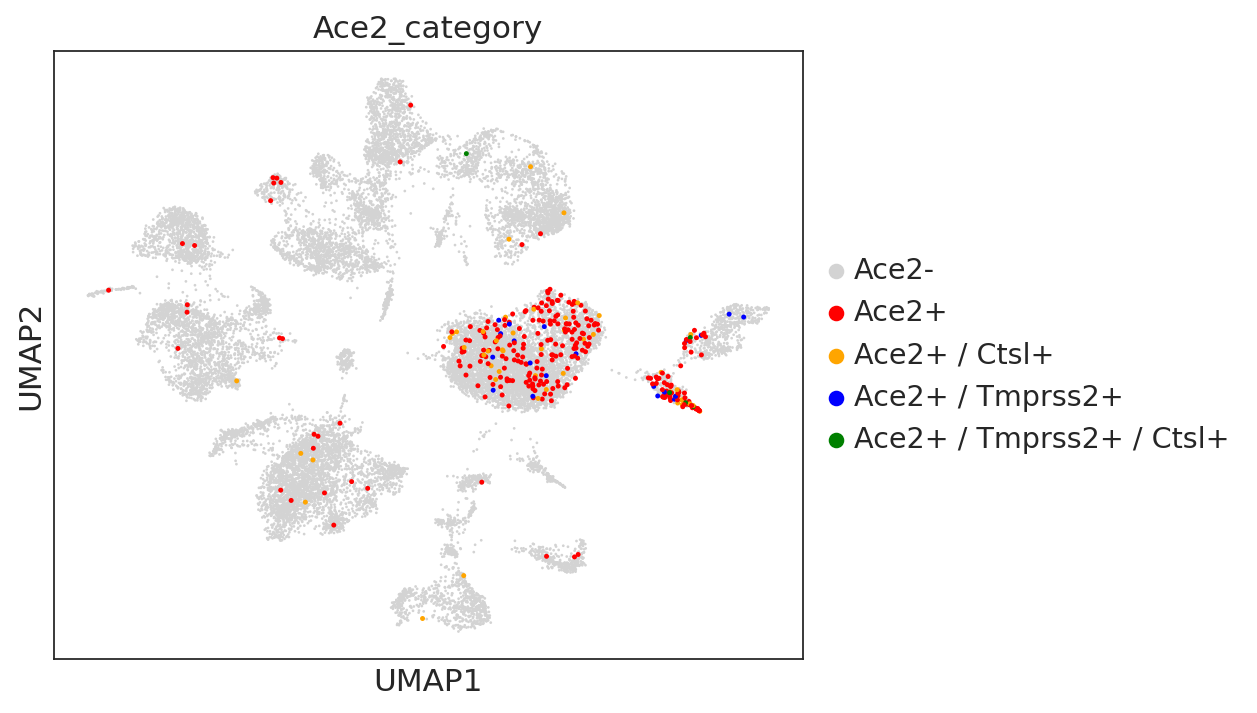

In [8]:
adata.uns["Ace2_category_colors"] = ["red", "orange", "blue", "green", "lightgray"]

fig1, ax = plt.subplots(figsize = (6, 5))
sc.pl.umap(adata[adata.obs.Ace2_category == "Ace2-"], color = "Ace2_category", show = False, ax = ax)
sc.pl.umap(adata[adata.obs.Ace2_category != "Ace2-"], color = "Ace2_category", show = False, ax = ax, 
            size = 20)
plt.show()

### Figure 5 e) Epithelial Marker Genes

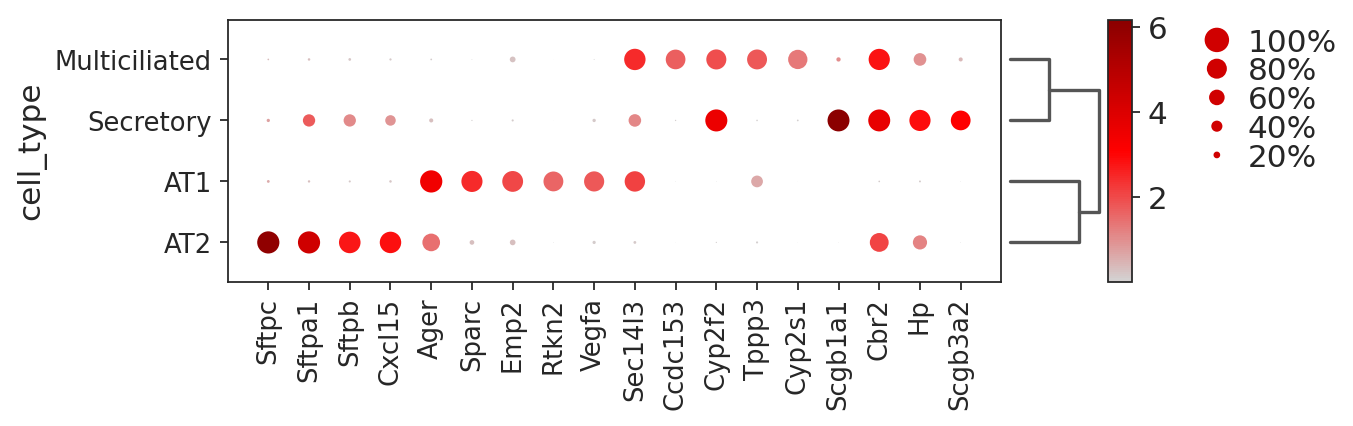

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[6.3, 0.8, 0.2, 0.5, 0.25])

In [9]:
epithel_cells = adata.obs.cell_type.isin(["AT2", "AT1", "Multiciliated", "Secretory"])
sub = adata[epithel_cells].copy()

sc.tl.dendrogram(sub, groupby = "cell_type")
sc.pl.dotplot(sub, var_names = adata.var_names[3:], groupby = "cell_type", color_map = gray_red, dendrogram = True)

### Figure 5 f) Relative proportion of Ace2+ cells in Secretory and AT2 cell population
#### Secretory cells

In [10]:
adata.obs.Ace2_positive.cat.reorder_categories(["Ace2-", "Ace2+"], inplace = True)
cells = adata.obs.cell_type == "Secretory"

xlabel = "condition"
cols = ["lightgray", "red"]

order = adata[cells].obs[xlabel].cat.categories.values
relFreqs = calc_relFreq(adata[cells], group_by = "Ace2_positive", xlabel = xlabel)
relFreqs

,Ace2-,Ace2+,condition
FA-2m-1,0.714286,0.285714,filtered air
FA-2m-2,0.857143,0.142857,filtered air
FA-2m-3,0.739130,0.260870,filtered air
FA-4m-1,0.850000,0.150000,filtered air
FA-4m-2,0.571429,0.428571,filtered air
FA-4m-3,0.833333,0.166667,filtered air
FA-6m-1,0.833333,0.166667,filtered air
FA-6m-2,1.000000,0.000000,filtered air
FA-6m-3,0.888889,0.111111,filtered air
SMK-2m-1,0.600000,0.400000,smoked


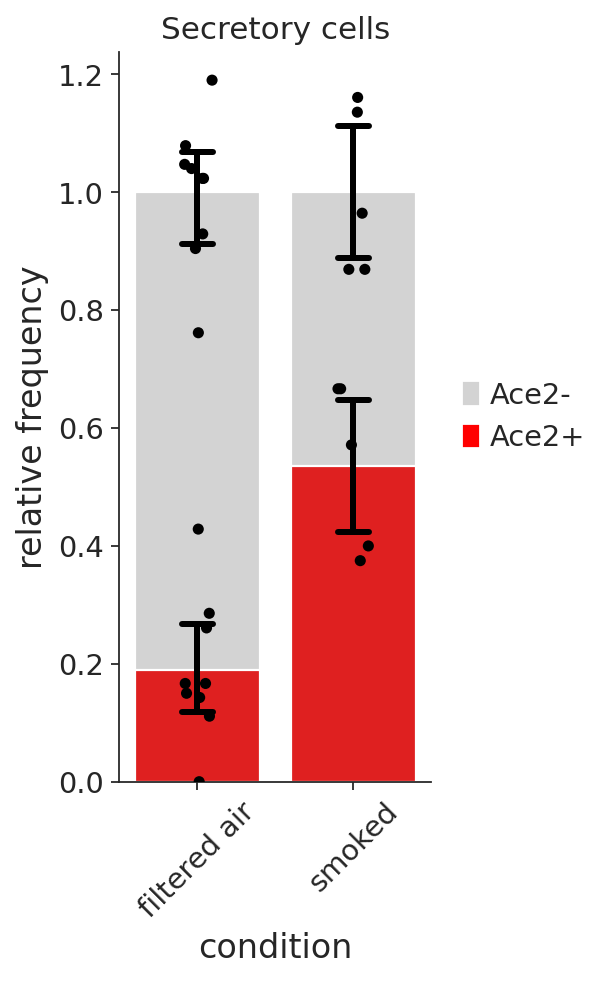

In [11]:
plot_cluster_composition(relFreqs, xlabel = xlabel, figsize = (2.5, 6), order = None, 
                         errbar = True, cols = cols, width = 0.8, capsize = 0.2, cell_type = "Secretory cells")

#### AT2 cells

In [12]:
cells = adata.obs.cell_type == "AT2"

order = adata[cells].obs[xlabel].cat.categories.values
relFreqs = calc_relFreq(adata[cells], group_by = "Ace2_positive", xlabel = xlabel)
relFreqs

,Ace2-,Ace2+,condition
FA-2m-1,0.956140,0.043860,filtered air
FA-2m-2,0.973485,0.026515,filtered air
FA-2m-3,0.963855,0.036145,filtered air
FA-4m-1,0.985321,0.014679,filtered air
FA-4m-2,0.971014,0.028986,filtered air
FA-4m-3,0.970904,0.029096,filtered air
FA-6m-1,0.990426,0.009574,filtered air
FA-6m-2,0.750000,0.250000,filtered air
FA-6m-3,1.000000,0.000000,filtered air
SMK-2m-1,1.000000,0.000000,smoked


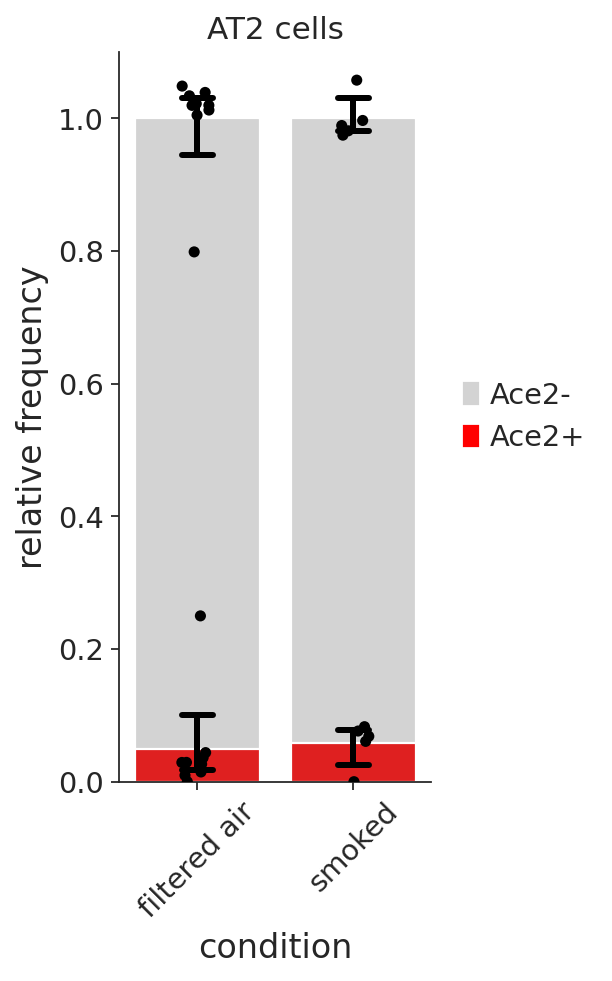

In [13]:
plot_cluster_composition(relFreqs, xlabel = xlabel, figsize = (2.5, 6), order = None, 
                         errbar = True, cols = cols, width = 0.8, capsize = 0.2, cell_type = "AT2 cells")

### Figure 5 g) Ace2 Expression levels in Secretory cells

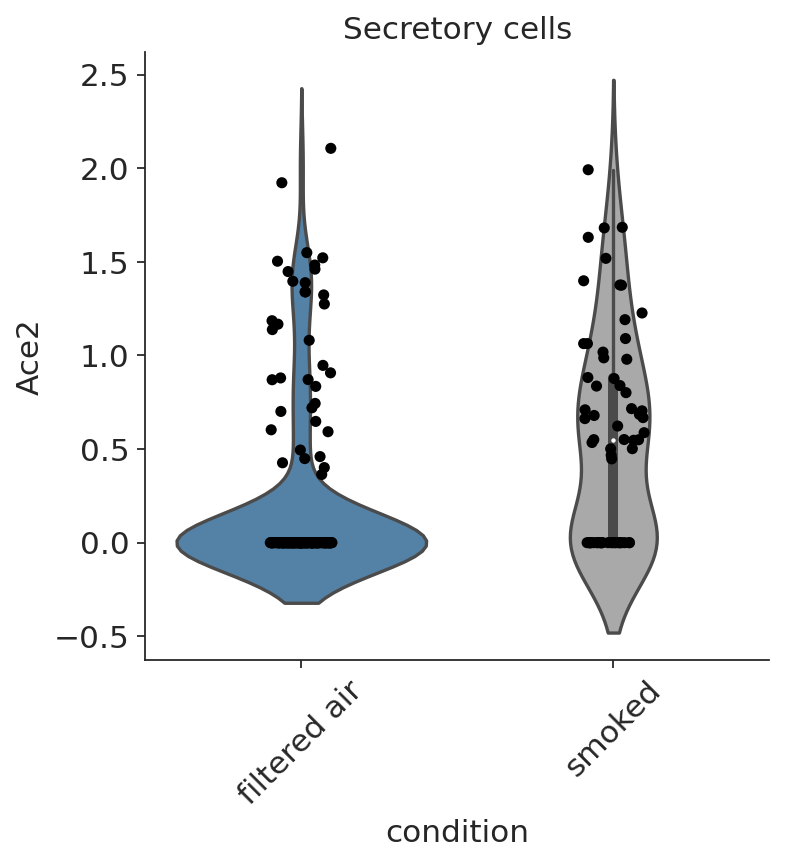

In [14]:
xlabel = "condition"
cols = ["steelblue", "darkgray"]

cells = adata.obs.cell_type == "Secretory"
ace2 = sc.get.obs_df(adata[cells], keys = ["Ace2", xlabel], use_raw = False)

fig, ax = plt.subplots()
fig.set_size_inches((5, 5))

fig = sb.violinplot(data = ace2, x = xlabel, y = "Ace2", palette = cols) 
fig = sb.stripplot(data = ace2, x = xlabel, y = "Ace2", palette = ["black"])
fig.set_xticklabels(fig.get_xticklabels(), rotation = 45)
fig.set_title('Secretory cells')
sb.despine()
plt.show()

### Figure 5 h) Ace2 Expression levels in AT2 cells

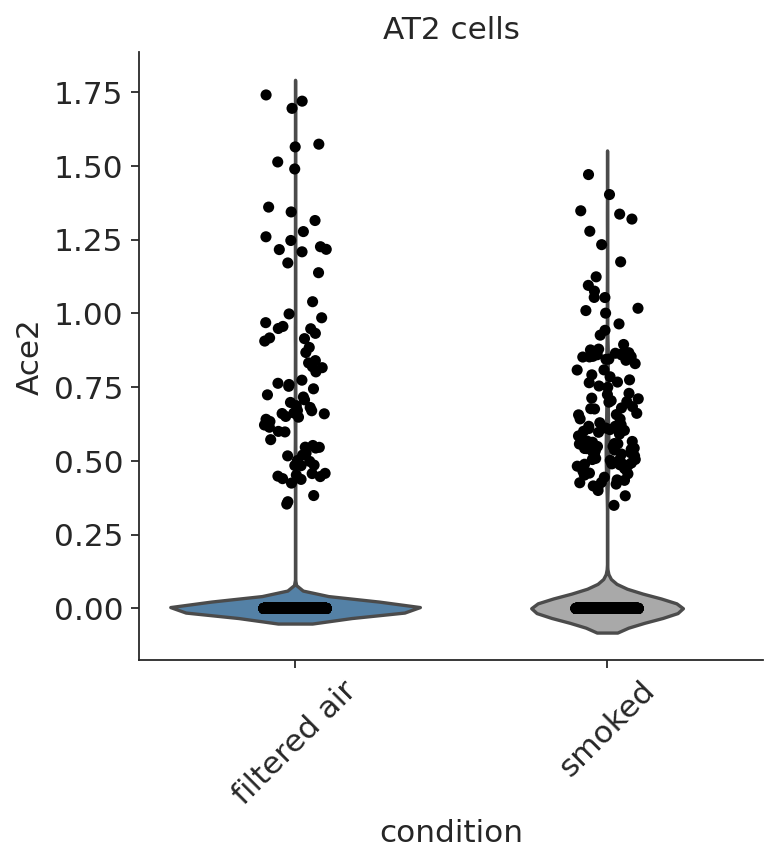

In [15]:
cells = adata.obs.cell_type == "AT2"
ace2 = sc.get.obs_df(adata[cells], keys = ["Ace2", xlabel], use_raw = False)

fig, ax = plt.subplots()
fig.set_size_inches((5, 5))

fig = sb.violinplot(data = ace2, x = xlabel, y = "Ace2", palette = cols) 
fig = sb.stripplot(data = ace2, x = xlabel, y = "Ace2", palette = ["black"])
fig.set_xticklabels(fig.get_xticklabels(), rotation = 45)
fig.set_title('AT2 cells')
sb.despine()
plt.show()